In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

In [2]:
BATCH_SIZE = 10
IMAGE_SIZE = 200
CHANNELS = 3
EPOCHS = 5

In [3]:
from zipfile import ZipFile

In [5]:
with ZipFile('/content/drive/MyDrive/pokemondata.zip','r') as zipObj:
  zipObj.extractall('drive/MyDrive/pokemonextracted')

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("drive/MyDrive/pokemonextracted",shuffle = True,image_size = (IMAGE_SIZE,IMAGE_SIZE),batch_size = BATCH_SIZE)

Found 6820 files belonging to 1 classes.


In [7]:
class_names = dataset.class_names
class_names

['PokemonData']

(10, 200, 200, 3)
[0 0 0 0 0 0 0 0 0 0]


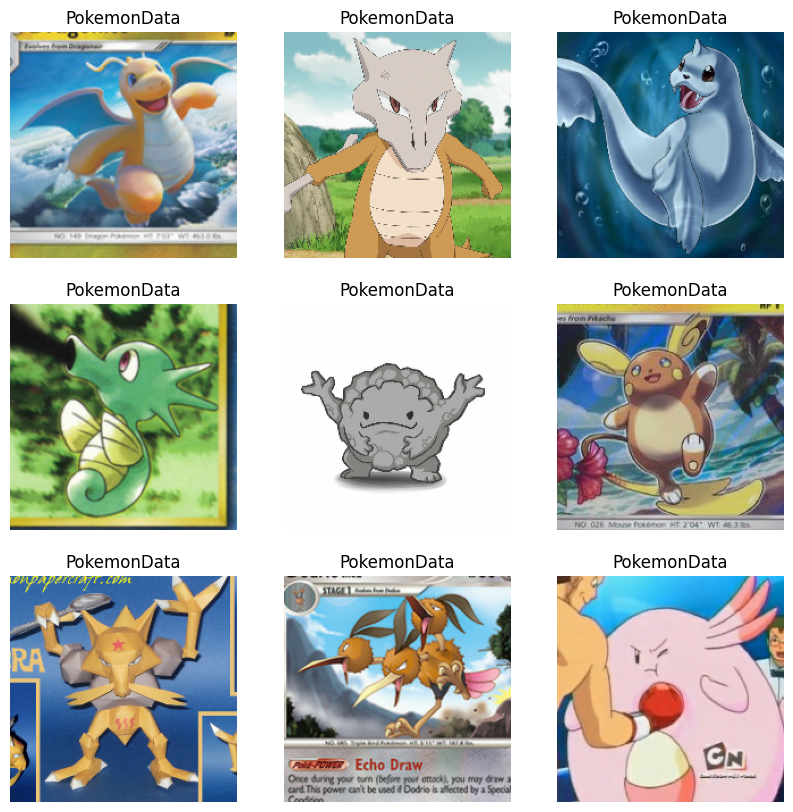

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(0,9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2)
])

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7000

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)), layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(500, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(10000, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (10, 200, 200, 3)         0         
                                                                 
 sequential_1 (Sequential)   (10, 200, 200, 3)         0         
                                                                 
 conv2d (Conv2D)             (10, 198, 198, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (10, 99, 99, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (10, 97, 97, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (10, 48, 48, 64)         0         
 2D)                                                  

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5
)

Epoch 1/5
545/545 [==============================] - 761s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
545/545 [==============================] - 760s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
545/545 [==============================] - 762s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
545/545 [==============================] - 771s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
545/545 [==============================] - 781s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [27]:
scores = model.evaluate(test_ds)


69/69 [==============================] - 14s 197ms/step - loss: 0.0000e+00 - accuracy: 1.0000


In [28]:
history.params
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
history.history["loss"]


[0.0, 0.0, 0.0, 0.0, 0.0]

In [33]:
history.history["accuracy"]

[1.0, 1.0, 1.0, 1.0, 1.0]

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

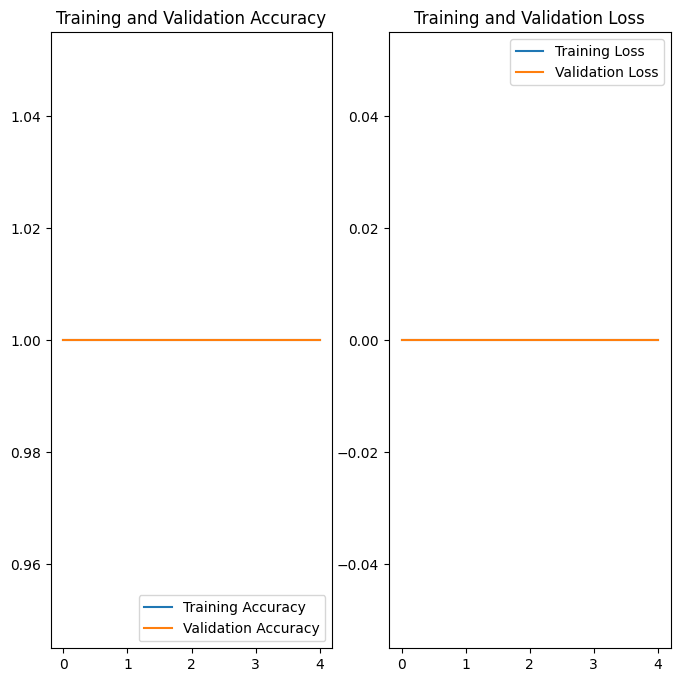

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
model.save('pokemon classifier')